In [1]:
import numpy as np
import pandas as pd
import spacy
import torch

from matplotlib import pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.cluster import KMeans, DBSCAN
from hdbscan import HDBSCAN

torch.manual_seed(42)
torch.backends.cuda.deterministic = True

%matplotlib inline

For building sentence embeddings we will use `sentence-transformers/paraphrase-multilingual-mpnet-base-v2"` model:

In [2]:
sent_emb_model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-mpnet-base-v2", device="cuda")

# Prepare data

Loading our preprocessed data:

In [3]:
df = pd.read_csv('./data/processed_dataset.csv')
df

,channelname,Date,content,lang,Date_day,text,tokens,token_text
0,kyivpolitics,2023-08-01 09:45:38,Отбой. Угрозы для столицы нет\n\nКиев. Главное...,ru,2023-08-01,отбой угрозы для столицы нет,"['отбой', 'угрозы', 'столицы']",отбой угрозы столицы
1,kyivpolitics,2023-08-01 10:03:38,На 8 перекрестках Киева в пилотном режиме внед...,ru,2023-08-01,на 8 перекрестках киева в пилотном режиме внед...,"['8', 'перекрестках', 'пилотном', 'режиме', 'в...",8 перекрестках пилотном режиме внедрят смежную...
2,kyivpolitics,2023-08-01 14:42:31,⚡️НБУ отозвал банковскую лицензию Конкорд Банк...,ru,2023-08-01,нбу отозвал банковскую лицензию конкорд банка ...,"['нбу', 'отозвал', 'банковскую', 'лицензию', '...",нбу отозвал банковскую лицензию конкорд банка ...
3,kyivpolitics,2023-08-01 15:37:34,Завтра синоптики прогнозируют небольшой дождь ...,ru,2023-08-01,завтра синоптики прогнозируют небольшой дождь ...,"['завтра', 'синоптики', 'прогнозируют', 'небол...",завтра синоптики прогнозируют небольшой дождь ...
4,kyivpolitics,2023-08-01 13:06:08,А вот и сам снятый советский герб \n\nКиев. Гл...,ru,2023-08-01,а вот и сам снятый советский герб,"['снятый', 'советский', 'герб']",снятый советский герб
...,...,...,...,...,...,...,...,...
28914,hmarochos,2023-10-27 04:56:20,🎨 Художницю зобовʼязали замалювати мурал на Сі...,uk,2023-10-27,художницю зобовʼязали замалювати мурал на січо...,"['художницю', 'зобовʼязали', 'замалювати', 'му...",художницю зобовʼязали замалювати мурал січових...
28915,hmarochos,2023-10-27 06:12:15,🚧 Львів хоче отримати 50 млн євро на реконстру...,uk,2023-10-27,львів хоче отримати 50 млн євро на реконструкц...,"['львів', 'хоче', 'отримати', '50', 'євро', 'р...",львів хоче отримати 50 євро реконструкцію вули...
28916,hmarochos,2023-10-27 05:38:42,🙈 На Набережно-Хрещатицькій самовільно влаштув...,uk,2023-10-27,на набережно хрещатицькій самовільно влаштувал...,"['набережно', 'хрещатицькій', 'самовільно', 'в...",набережно хрещатицькій самовільно влаштували п...
28917,semenovatut,2023-10-27 11:50:39,Може залишити Пушкіна?\nБуде об‘єктом перформа...,uk,2023-10-27,може залишити пушкіна буде об єктом перформансів,"['залишити', 'пушкіна', 'об', 'єктом', 'перфор...",залишити пушкіна об єктом перформансів


Loading uk and ru tokenizers:

In [4]:
tokenizer = {
    'uk': spacy.load("uk_core_news_sm"),
    'ru': spacy.load("ru_core_news_sm")
}

Building sentence embeddings:

In [5]:
sent_embeddings = sent_emb_model.encode(df["token_text"].to_list(), batch_size=100)

And saving the for the future:

In [6]:
np.save(
    "./data/KyivChannels_Dataset_sent_embeddings.npy",
    sent_embeddings
)

Choose texts from one channel to see how different clustering algorithms work.

In [7]:
indices = df['channelname'] == 'novynylive'

In [8]:
sent_embeddings = np.load("./data/KyivChannels_Dataset_sent_embeddings.npy")
assert sent_embeddings.shape[0] == df.shape[0]

# Clustering
## PCA

Firstly, we will try PCA algorithm for dimensionality reduction as first step before clustering.

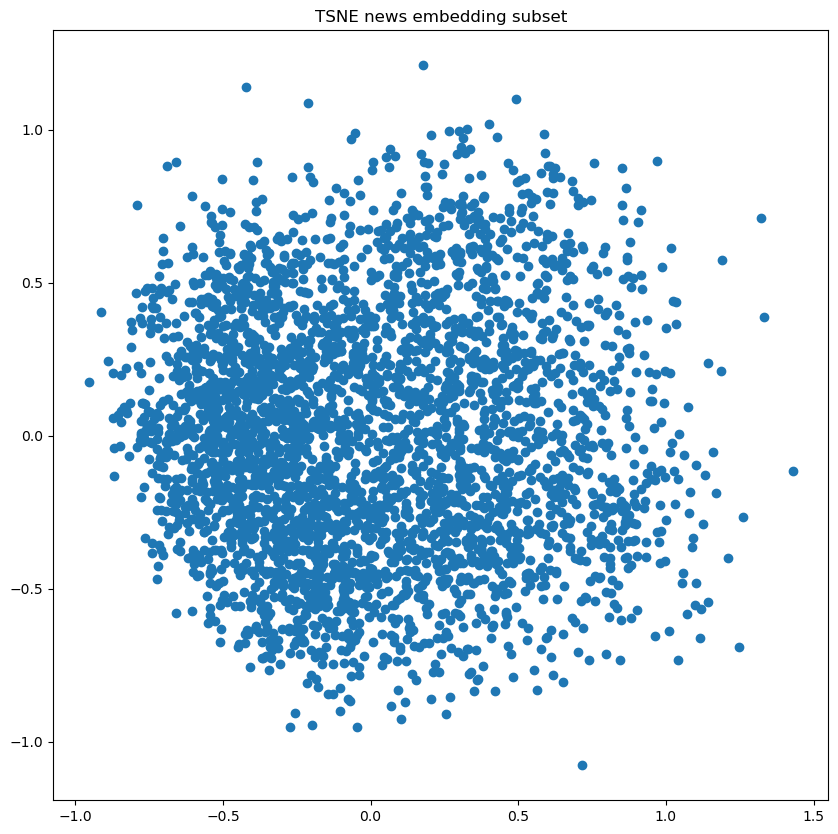

In [9]:
pca_news_embeddings_subset = PCA(64).fit_transform(
    sent_embeddings[indices]
)

pca_news_embeddings_draw_subset = PCA(2).fit_transform(
    sent_embeddings[indices]
)

plt.figure(figsize=(10, 10))
plt.title("PCA news embedding subset")
plt.scatter(pca_news_embeddings_draw_subset[:, 0], pca_news_embeddings_draw_subset[:, 1])
plt.show()

### KMEANS

C:\Users\Andrii\anaconda3\envs\IASA_NLP\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


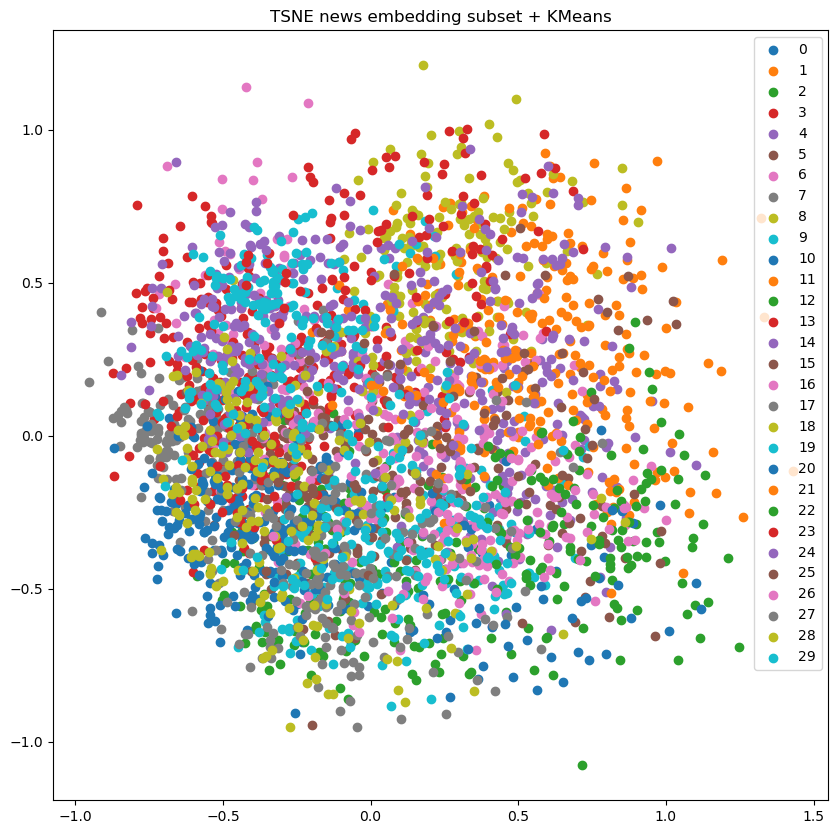

In [10]:
kmeans_clusts_news_embeddings_subset = KMeans(
    n_clusters=30,
    random_state=42,
    init="k-means++"
).fit_predict(pca_news_embeddings_subset)

plt.figure(figsize=(10, 10))
plt.title("PCA news embedding subset + KMeans")
for clust in np.unique(kmeans_clusts_news_embeddings_subset):
    plt.scatter(
        pca_news_embeddings_draw_subset[kmeans_clusts_news_embeddings_subset == clust, 0],
        pca_news_embeddings_draw_subset[kmeans_clusts_news_embeddings_subset == clust, 1],
        label=str(clust)
    )
plt.legend()
plt.show()

In [11]:
df[indices][kmeans_clusts_news_embeddings_subset == 0]['content'].sample(8, random_state=42).to_list()

['Палата представників США відправила у відставку спікера Маккарті\n\nЙого звинуватили в нібито укладанні таємної угоди з Байденом щодо підтримки України, яка має бути ухвалена після голосування за проміжний бюджет на 45 днів.',
 'Ілон Маск звільнив команду, відповідальну за боротьбу з дезінформацією у Twitter, після критики ЄС, — Politico\n\nВласник платформи X (раніше Twitter), заявив, що працівників звільнили через два дні після того, як віцепрезидентка Єврокомісії Вера Йоурова назвала Х «онлайн-платформою з найбільшою кількістю брехні». Звільнення зачепило кількох співробітників з Ірландії, які працюють в команді з усунення загроз, включно зі старшим менеджером Аароном Родеріксом.\n\nX має відповідати Закону про цифрові послуги ЄС, який вимагає, щоб великі технологічні платформи з більш ніж 45 млн користувачів в ЄС зменшували ризики дезінформаційних кампаній. Недотримання правил може призвести до масштабних штрафів у розмірі до 6% глобального річного доходу.',
 "⚡️Зеленський звільн

In [12]:
df[indices][kmeans_clusts_news_embeddings_subset == 1]['content'].sample(8, random_state=42).to_list()

["«Укренерго» повідомило про пошкоджені енергооб'єкти у західних та центральних регіонах \n\nБез світла залишилося 398 населених пунктів. Через наслідки атаки частково світла не було в Рівненській, Житомирській, Київській, Дніпропетровській, Харківській областях. Триває  відновлення.\n\n🇺🇦 Підпишись на Новини.LIVE",
 'За добу ЗСУ ліквідували ще 440 російських окупантів\n\nЗагальні втрати ворога за час повномасштабного вторгнення складають 278 570 військових.\n\n❤️ — Дякуємо захисникам і захисницям!',
 'За добу українські захисники знищили ще 800 окупантів\n\nЗагальні втрати ворога перевищують 289 тисяч росіян.\n\n🔥 — Дякуємо ЗСУ!',
 'Україна повернула тіла ще 64 загиблих захисників додому',
 'Авдіївська різня. Чому так різко зросла кількість російських втрат\n\n9 жовтня російські окупаційні війська розпочали наступ на місто Авдіївка, що розташоване неподалік від Донецька. І вже за наступні два тижні втрати ворога зросли в декілька разів. 19 жовтня, наприклад, окупанти за добу втратили 

In [13]:
df[indices][kmeans_clusts_news_embeddings_subset == 2]['content'].sample(8, random_state=42).to_list()

['У Києві суд взяв під варту водія, який скоїв смертельний наїзд на військовослужбовця, — поліція Києва\n\nТермін тримання під вартою — 2 місяці.\n\nКеруючи автомобілем «Хонда», водій рухався по автодорозі М-01 в напрямку Броварського проспекту у другій смузі для руху з трьох наявних, в умовах туману попереду побачив вантажний автомобіль та здійснив різке гальмування. \n\nУ результаті не впорався з керуванням та виїхав у крайню праву смугу для руху, де здійснив наїзд на військовослужбовця, якій ніс службу на блокпосту. Від отриманих травм потерпілий помер на місці події.',
 'У Чорноморську чоловік взяв у заручники власну родину\n\nСьогодні, близько 12:00 до правоохоронців надійшло повідомлення, що в одній із квартир міста на четвертому поверсі жінка просить про допомогу.\n\nНа місці події було встановлено, що в оселі знаходиться 29-річний місцевий мешканець, який тримає в заручниках свою дружину та маленьку доньку та погрожує завдати їм тілесні ушкодження. Тещу ж він відпустив.\xa0\n\n

After human analises of samples of groups above we can say that KMEANS + PCA algorithm works well enough, but there are still some exceptions that are not very suitable for these clusters.

### DBSCAN

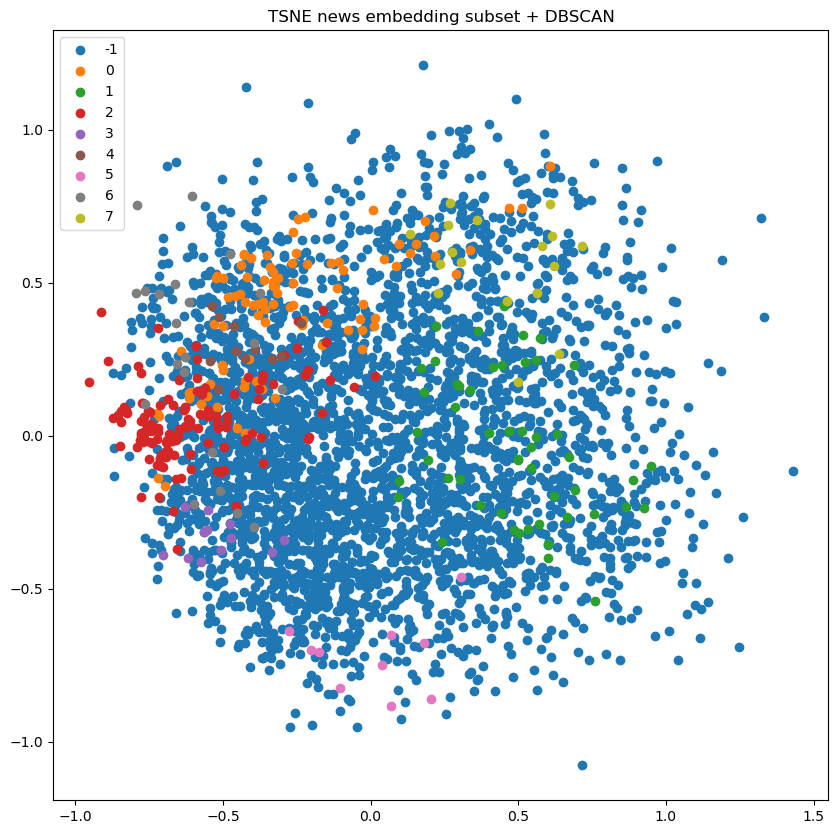

In [14]:
dbscan_clusts_news_embeddings_subset = DBSCAN(
    eps=0.2,
    min_samples=10,
    metric='cosine'
).fit_predict(pca_news_embeddings_subset)

plt.figure(figsize=(10, 10))
plt.title("PCA news embedding subset + DBSCAN")
for clust in np.unique(dbscan_clusts_news_embeddings_subset):
    plt.scatter(
        pca_news_embeddings_draw_subset[dbscan_clusts_news_embeddings_subset == clust, 0],
        pca_news_embeddings_draw_subset[dbscan_clusts_news_embeddings_subset == clust, 1],
        label=str(clust)
    )
plt.legend()
plt.show()

In [15]:
df[indices][dbscan_clusts_news_embeddings_subset == 0]['content'].sample(8, random_state=42).to_list()

['Південні регіони — загроза застосування ударних БпЛА, — Повітряні сили\n\n🇺🇦📞 Ми у Viber',
 'Львівщина — залишайтесь в укритті! Ракети рухаються у вашому напрямку, — Повітряні сили\n\n🇺🇦📞 Ми у Viber',
 'Повітряні сили повідомляють про ракетну небезпеку в Донецькій області\n\n🇺🇦📞 Ми у Viber',
 'Кілія, Ізмаїл —  ворожі БпЛА в Вашому напрямку, — Повітряні сили',
 'Загроза ракетно-дронових ударів по Україні висока, — Сергій Братчук\n\nПісля тимчасової паузи ворог знову вивів ракетоносії на бойове чергування в Чорне море. Наразі там продовжують чатувати три носії крилатих ракет «Калібр». Загальний залп — 16 ракет. \n\n«Ворог поки що не атакує, готується до атаки. Треба памʼятати, що війна триває. Втім, Сили оборони готові дати відсіч», — зазначив Братчук в етері телемарафону.\n\n🇺🇦 Новини.LIVE Одеса',
 'Рівненська область — загроза застосування ворогом ударних БпЛА, — Повітряні сили\n\n🇺🇦📞 Ми у Viber',
 'Повітряні сили повідомляють про загрозу застосування балістичного озброєння в Запоріж

In [16]:
df[indices][dbscan_clusts_news_embeddings_subset == 1]['content'].sample(8, random_state=42).to_list()

['У Львові вручили повістку експрокурору, який нещодавно відгуляв скандальне весілля\n\nПро це повідомляє Еспресо.Захід. Документ оформлювали у Личаківсько-Залізничному ОР ТЦК та СП.\n\n🇺🇦 Новини.LIVE Львів',
 'Наслідки ворожого обстрілу Обухівки на Дніпропетровщині: Новини.LIVE з місця події\n\nТериторію вже оглянули спеціалісти й пустили людей до своїх домівок. Місцеві почали розбирати завали. Кажуть, що майно відбудується, а головне — що самі залишилися живими.',
 'Галкін заспівав українською у Варшаві \n\nАртист, який разом із дружиною Аллою Пугачовою залишив РФ після повномасштабного вторгення, заспівав зі сцени пісню українського виконавця Андрія Миколайчука «Піду втоплюся».',
 'Миколаївські бійці знищують окупантів \n\n40 Окрема артилерійська бригада імені Великого князя Вітовта опублікувала відео знищення позицій військ РФ.\n\n🇺🇦 Новини.LIVE Одеса',
 'Окупанти вночі вкотре обстріляли Дніпропетровщину, — ОВА\n\nРосіяни атакували область ударними дронами. Бійці ЗСУ збили над регі

In [17]:
df[indices][dbscan_clusts_news_embeddings_subset == 2]['content'].sample(8, random_state=42).to_list()

['Потужний вибух в Одесі!\n\n🇺🇦 Новини.LIVE Одеса',
 '🔴 В Одесі було чутно звук вибуху',
 'У Запорізькій області вибухи, — моніторингові канали\n\n🇺🇦 Ми у Viber',
 'У Севастополі лунають вибухи, — місцеві ЗМІ',
 '🛑В Одесі лунають вибухи',
 '❗️У Миколаєві пролунали потужні вибухи, — моніторингові канали',
 'Вибухи лунають в окупованому Севастополі, — місцеві пабліки',
 'В окупованому Бердянську пролунав вибух, а після — звуки автоматної черги, — місцеві пабліки']

DBSCAN clustering, after applying PCA algorithm for dimensionality reduction, gives lower amount of clusters then we set in previous, 9 in particular. As we can see clusters 0 and 2 have only similar themed data, but in the cluster 1 there is traceable distortion in topics.

### HDBSCAN

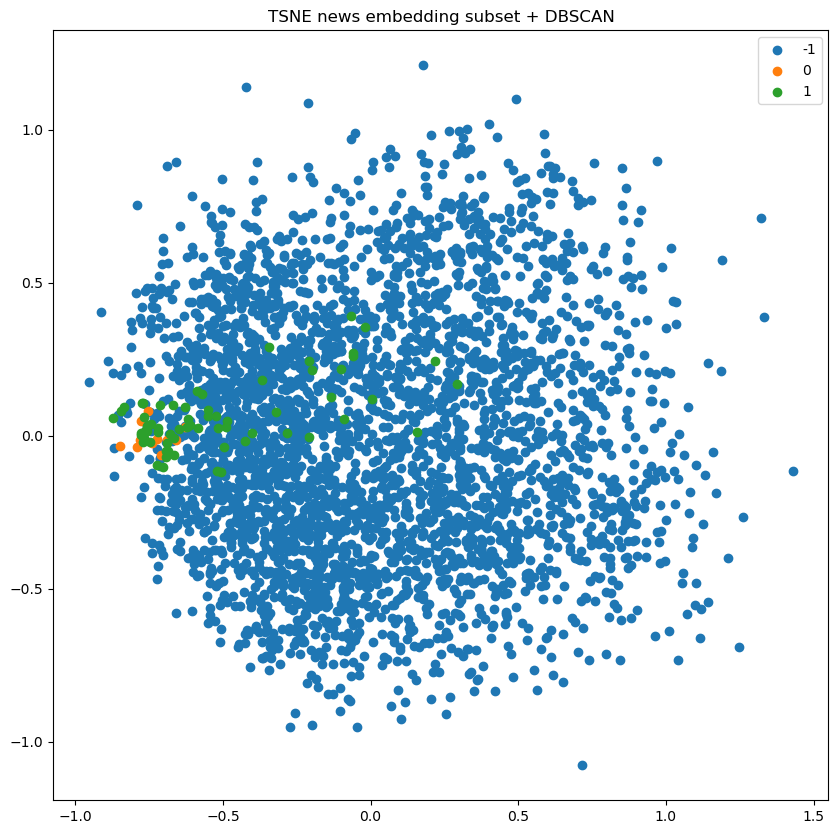

In [22]:
hdbscan_clusts_news_embeddings_subset = HDBSCAN(
    min_cluster_size=10,
    metric='euclidean', 
    cluster_selection_method='eom', 
    prediction_data=True
).fit_predict(pca_news_embeddings_subset)

plt.figure(figsize=(10, 10))
plt.title("PCA news embedding subset + DBSCAN")
for clust in np.unique(hdbscan_clusts_news_embeddings_subset):
    plt.scatter(
        pca_news_embeddings_draw_subset[hdbscan_clusts_news_embeddings_subset == clust, 0],
        pca_news_embeddings_draw_subset[hdbscan_clusts_news_embeddings_subset == clust, 1],
        label=str(clust)
    )
plt.legend()
plt.show()

In [19]:
df[indices][hdbscan_clusts_news_embeddings_subset == 0]['content'].sample(8, random_state=42).to_list()

['❗️ На Херсонщині лунають вибухи, — місцеві ЗМІ',
 'ЗМІ повідомляють про вибухи у Запоріжжі',
 'У Хмельницькій області знову чути вибухи, — місцеві ЗМІ\n\n🇺🇦📞 Ми у Viber',
 '❗️В Херсоні пролунав потужний вибух, — місцеві ЗМІ',
 'У Севастополі лунають вибухи, — місцеві ЗМІ',
 'У Херсоні знову лунають вибухи, — місцеві ЗМІ',
 'Вибухи в Херсоні, — місцеві ЗМІ\n\n🇺🇦📞 Ми у Viber',
 'У Миколаєві лунають вибухи, — ЗМІ']

In [20]:
df[indices][hdbscan_clusts_news_embeddings_subset == 1]['content'].sample(8, random_state=42).to_list()

['Повідомляють про вибухи у Дніпрі',
 'У Дніпрі лунають вибухи\n\nПеред цим Повітряні сили попереджали про ракетну небезпеку в області.',
 "В ОК «Південь» показали наслідки нічної атаки РФ по Одещині\n\nУнаслідок атаки та влучань виникли пожежі на промислових та портових об'єктах, пошкоджено елеватор.\n\n🇺🇦 Новини.LIVE Одеса",
 'У Запоріжжі пролунали вибухи, — місцеві пабліки\n\nПовітряні Сили повідомляли про ракетну небезпеку в регіоні.',
 'У Харкові пролунав вибух!',
 'У Херсоні лунають вибухи, — МВА\n\nАрмія РФ обстрілює місто з тимчасово окупованого лівого берега!\n\n🇺🇦 Новини.LIVE Одеса',
 'Повторні вибухи на Хмельниччині\n\n🇺🇦📞 Ми у Viber',
 'У Херсоні пролунали вибухи, — моніторингові канали\n\n🇺🇦📞 Ми у Viber']

HDBSCAN clustering algorithm with applying PCA as preprocessing, gives the least amount of clusters. This method performs suboptimally on our dataset, as it fails to effectively separate different topics, leading to similar themes being present in two different clusters.

## TSNE

Secondly, we will try TSNE algorithm for dimensionality reduction as first step before clustering.

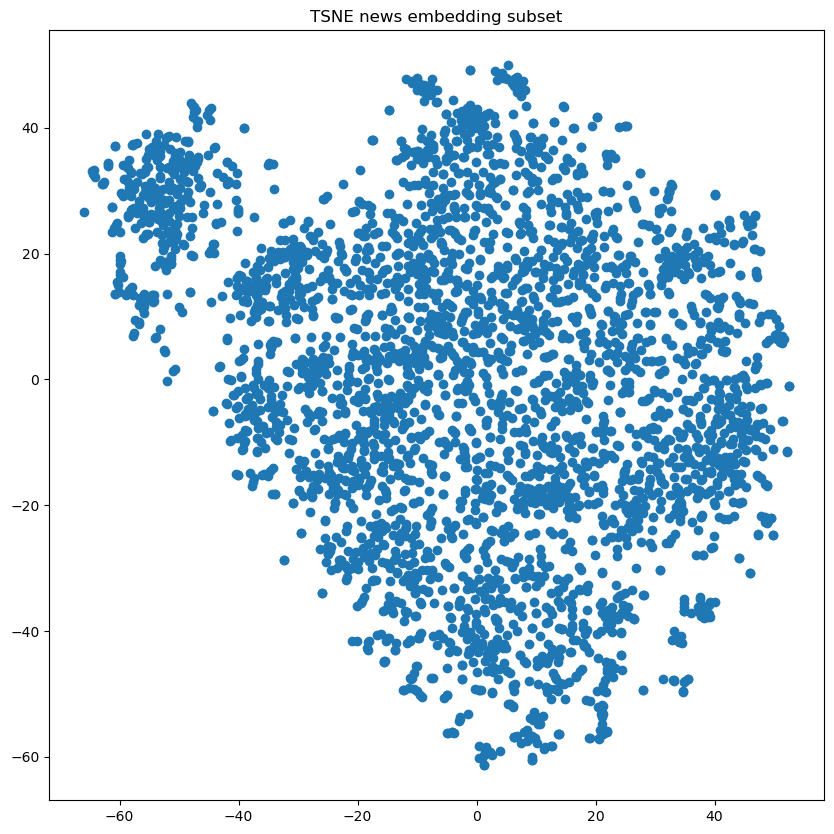

In [23]:
tsne_news_embeddings_subset = TSNE(3, random_state=42).fit_transform(
    pca_news_embeddings_subset
)
tsne_news_embeddings_draw_subset = TSNE(2, random_state=42).fit_transform(
    pca_news_embeddings_subset
)

plt.figure(figsize=(10, 10))
plt.title("TSNE news embedding subset")
plt.scatter(tsne_news_embeddings_draw_subset[:, 0], tsne_news_embeddings_draw_subset[:, 1])
plt.show()

### KMEANS

C:\Users\Andrii\anaconda3\envs\IASA_NLP\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


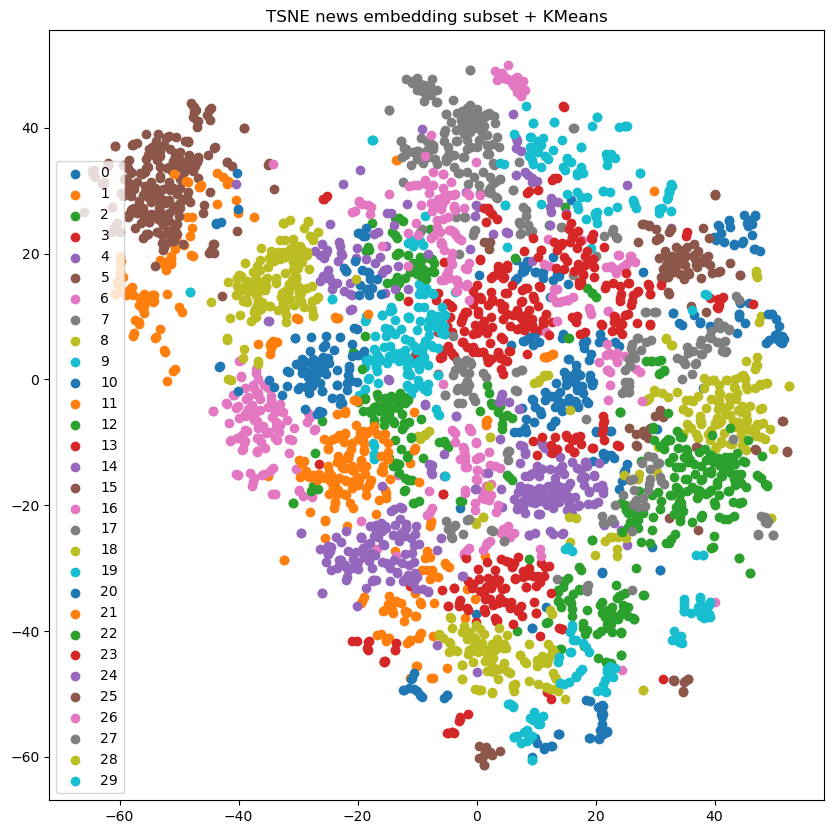

In [24]:
kmeans_clusts_news_embeddings_subset = KMeans(
    n_clusters=30,
    random_state=42,
    init="k-means++"
).fit_predict(tsne_news_embeddings_subset)

plt.figure(figsize=(10, 10))
plt.title("TSNE news embedding subset + KMeans")
for clust in np.unique(kmeans_clusts_news_embeddings_subset):
    plt.scatter(
        tsne_news_embeddings_draw_subset[kmeans_clusts_news_embeddings_subset == clust, 0],
        tsne_news_embeddings_draw_subset[kmeans_clusts_news_embeddings_subset == clust, 1],
        label=str(clust)
    )
plt.legend()
plt.show()

In [25]:
df[indices][kmeans_clusts_news_embeddings_subset == 0]['content'].sample(8, random_state=42).to_list()

['Момент безмежного щастя: песик дочекався свого господаря з війни\n\nВідео: rem__amstaff',
 'Залужний зустрівся з начальником Штабу оборони Великої Британії адміралом сером Тоні Радакіним\n\n«Розповів про наші оборонні та наступальні дії на фронті. Обговорили актуальні потреби українського війська. Особливо наголосив на необхідності посилення нашої протиповітряної оборони», — підсумував зустріч головнокомандувач ЗСУ.',
 'На Одещині загинув дідусь, який намагався витягнути матрац з онучками на берег\n\nСьогодні зранку до Служби Порятунку надійшло повідомлення про те, що в Одеському районі під час відпочинку на місцевому ставку, намагаючись витягнути на берег надувний матрац з двома онуками, потонув громадянин 1958 року народження. Малечу, на щастя, врятували підлітки до прибуття підрозділів ДСНС.\n\n🇺🇦 Новини.LIVE Одеса',
 'Так виглядає людяність: боєць вирішив допомогти котикові втамувати спрагу, хоч відповідної посудини для цього не було, військовий знайшов вихід',
 "🔞 Увага! На віде

In [26]:
df[indices][kmeans_clusts_news_embeddings_subset == 1]['content'].sample(8, random_state=42).to_list()

['Рук транспорту Кримським мостом знову призупинили, — росЗМІ',
 'Ця зима для українців буде важчою, ніж минулорічна, — ДТЕК\n\nГолова енергохолдингу Максим Тімченко заявив, що цьогоріч атаки окупантів можуть бути інтенсивнішими, а через попередні обстріли в Україні вже менші резерви потужності. Водночас і наші військові, і енергетики готові реагувати на можливі ворожі удари.',
 'У Криму гучно, повідомляють місцеві пабліки\n\nФото: Крымский ветер',
 'У Києві агент ФСБ хотів вступити до школи «Армії дронів», щоб шпигувати за українськими військовими: його спіймала СБУ, тепер зраднику загрожує довічне\n\nПісля зарахування до закладу 49-річний київський підприємець мав встановити локації полігонів Сил оборони, де курсантів навчають управляти ударними та розвідувальними безпілотниками. Після чого окупанти планували вгатити по цих місцях ракетами. Крім цього чоловік ходив вулицями Києва і фіксував локації українських захисників на території міста.\n\n«Спалився» агент ФСБ в Telegram — він пу

In [27]:
df[indices][kmeans_clusts_news_embeddings_subset == 2]['content'].sample(8, random_state=42).to_list()

['Білий дім провів відеоконференцію з лідерами країн G7, Польщі та Румунії з приводу допомоги Україні, — Rzeczpospolita\n\nРозмова відбувалася за ініціативи Байдена після того, як Конгрес США ухвалив законопроєкт про тимчасові державні витрати, який не включає допомогу Україні.\n\nЗміст розмови не розголошується. Відомо, що Байден запевнив, що США збережуть свою допомогу Україні, попри проблеми з прийняттям Конгресом бюджету.',
 'До Києва з робочим візитом прибув міністр оборони Франції Себастьян Лекорню\n\nРазом з ним до столиці прибули 20 представників підприємств оборонної промисловості.',
 'РФ БʼЄ ПО ХАРКОВУ / Нові «тези» Путіна / Захід штовхає нас до виборів? / Прямий ефір',
 'Зеленський прибув із візитом до Бельгії, — Reuters\n\nОчікується, що президент візьме участь у засіданні «Рамштайну» та проведе низку зустрічей.',
 "Зеленський приїхав на Закарпаття\n\nТут президент провів нараду з українськими дипломатами за кордоном та назвав основні пріоритети у їхній роботі: «формула мир

After human analises of samples of groups above we can say that KMEANS + TSNE algorithm fails to manage data in proper clusters, since each cluster has diverse topics in it.

### DBSCAN

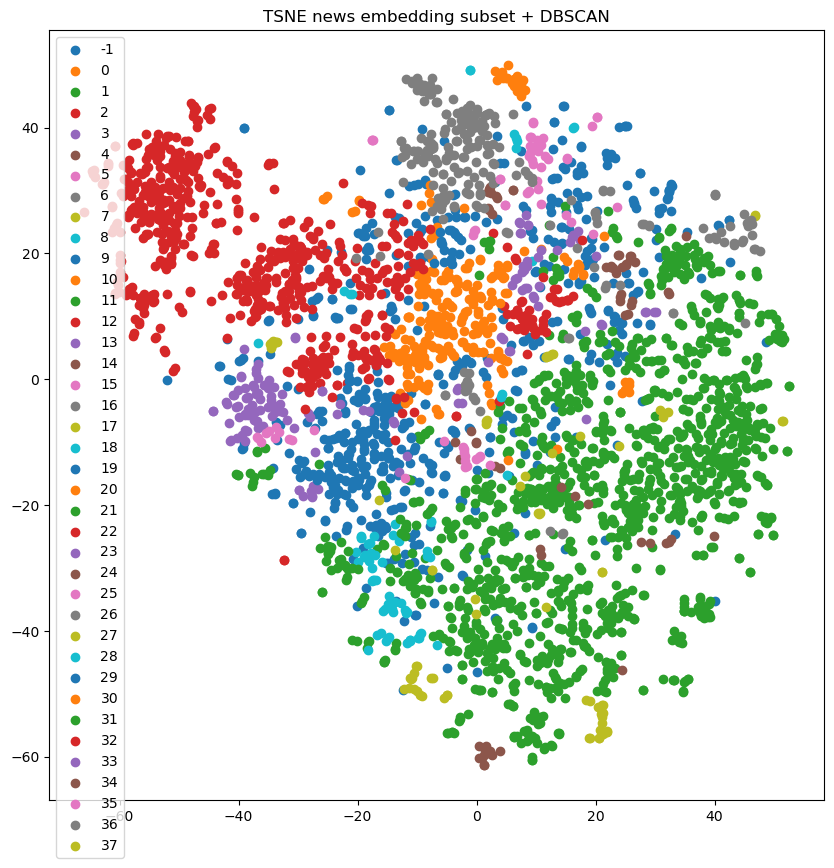

In [28]:
dbscan_clusts_news_embeddings_subset = DBSCAN(
    eps=0.005,
    min_samples=10,
    metric='cosine'
).fit_predict(tsne_news_embeddings_subset)

plt.figure(figsize=(10, 10))
plt.title("TSNE news embedding subset + DBSCAN")
for clust in np.unique(dbscan_clusts_news_embeddings_subset):
    plt.scatter(
        tsne_news_embeddings_draw_subset[dbscan_clusts_news_embeddings_subset == clust, 0],
        tsne_news_embeddings_draw_subset[dbscan_clusts_news_embeddings_subset == clust, 1],
        label=str(clust)
    )
plt.legend()
plt.show()

In [29]:
df[indices][dbscan_clusts_news_embeddings_subset == 0]['content'].sample(8, random_state=42).to_list()

['Внаслідок ворожого обстрілу села Подоли у Куп’янському районі загинула жінка 58 років, чоловік 66 років отримав поранення — Синєгубов\n\nЗруйнований приватний будинок, виникла пожежа у господарчій споруді.\n\n🇺🇦 Новини.LIVE Харків',
 '«Щодня ця робота дивує»: на Хмельниччині чоловік нібито намагався вплав утекти від працівників ТЦК\n\nНа відео, що шириться соцмережами, видно, як чоловік, покинувши свій велосипед, вирішив утекти від військовослужбовців водоймою.',
 'РФ обстріляла з танків житловий будинок в Авдіївці, сталася пожежа, — ОВА \n\nПостраждалих на місці немає. Мешканці будинку виїхали. Сьогодні місто вже двічі атакували з танків, також завдавали ударів з артилерії та «Градів», додали в адміністрації.   \n \nФото: Донецька ОВА',
 'Кількість поранених внаслідок удару по терміналу «Нової пошти» під Харковом зросла до 17 людей\n\nЩе один працівник підприємства отримав осколкові поранення, але відмовився від госпіталізації. Про це повідомили в облпрокуратурі.\n\n🇺🇦 Новини.LIVE Х

In [30]:
df[indices][dbscan_clusts_news_embeddings_subset == 1]['content'].sample(8, random_state=42).to_list()

['Йдеться про нардепа від групи «Довіра» Роберта Горвата, — «РБК-Україна»',
 'Ексзаступник міністра оборони і керівник департаменту отримали підозри від ДБР за закупівлю неякісних бронежилетів на 250 млн грн\n\nВони замовили за кордоном засоби індивідуального захисту поганої якості. Внесли за них 100% передоплату і порушили процедуру контролю за якістю товару. У результаті — бійці мають бронежилети, які не рятують їхні життя.',
 'Залужний провів розмову з генералом Крістофером Каволі\n\nГоловнокомандувач ЗСУ ознайомив Верховного головнокомандувача Обʼєднаних збройних Сил НАТО в Європі з обстановкою на фронті та першочерговими потребами українських військових.\n\n«Питання посилення нашої протиповітряної оборони залишається пріоритетним. Вдячний партнерам за допомогу та активну взаємодію задля визволення української території від російських окупантів», — зазначив Залужний.',
 'Росія почала на сході України найбільший наступ із січня, — британська розвідка\n\nМіноборони Великої Британії у

In [31]:
df[indices][dbscan_clusts_news_embeddings_subset == 2]['content'].sample(8, random_state=42).to_list()

["Іранське видання Iran Newspaper привітало читачів із 1000 вбитих громадян Ізраїлю \n\nВідповідний пост з'явився на сторінці газети в мережі Х (Twitter).",
 'Іран пригрозив Ізраїлю відповіддю на «військові злочини» у Газі\n\nГлава МЗС Ірану Хоссейн Амір-Абдоллахіян назвав атаку ХАМАС на Ізраїль «спонтанним кроком у відповідь на постійні та провокаційні злочини» ізраїльської армії, зокрема напад на мечеть Аль-Акса. \n\n«Армія Ізраїлю не може поставити Газу в повну облогу, бомбардувати цивільних осіб, скоювати військові злочини і не чекати жодної реакції на ці злочини», — заявив Амір-Абдоллахіян.\n\nРаніше Тегеран відкрито підтримав напад ХАМАС на Ізраїль.',
 'Повітряні сили повідомляють про ракетну небезпеку в Донецькій області\n\n🇺🇦📞 Ми у Viber',
 'Ізраїльська армія провела перші наземні локальні операції в Секторі Гази, — The Israel Times\n\nПіхотні підрозділи за підтримки бронетехніки провели локальні рейди, спрямовані на пошук захоплених бойовиками ХАМАС заручників. Ізраїльтяни вия


DBSCAN + TSNE algorithm gives 39 different clusters, that is higher amount of clusters then we had in previous. Similar to previous this algorithm has failed to clusterize given data (as we can verify above).

### HDBSCAN

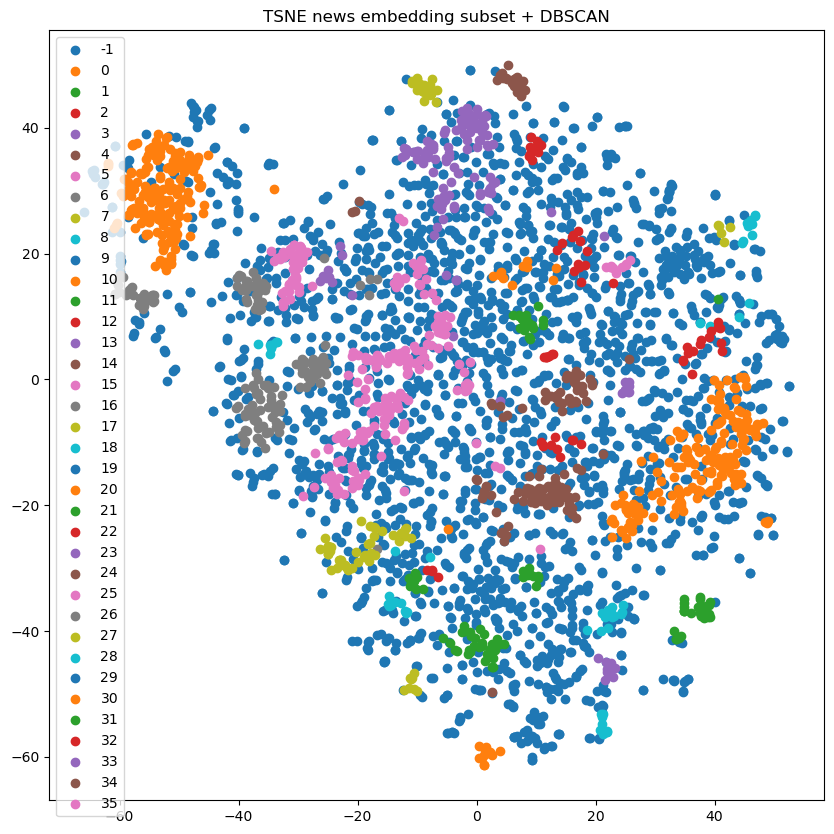

In [32]:
hdbscan_clusts_news_embeddings_subset = HDBSCAN(
    min_cluster_size=10,
    max_cluster_size=200,
).fit_predict(tsne_news_embeddings_subset)

plt.figure(figsize=(10, 10))
plt.title("TSNE news embedding subset + DBSCAN")
for clust in np.unique(hdbscan_clusts_news_embeddings_subset):
    plt.scatter(
        tsne_news_embeddings_draw_subset[hdbscan_clusts_news_embeddings_subset == clust, 0],
        tsne_news_embeddings_draw_subset[hdbscan_clusts_news_embeddings_subset == clust, 1],
        label=str(clust)
    )
plt.legend()
plt.show()

In [33]:
df[indices][hdbscan_clusts_news_embeddings_subset == 0]['content'].sample(8, random_state=42).to_list()

['Російські окупанти проводять примусові медогляди українських дітей на ТОТ, — ЦНС\n\nОфіційно це необхідно для проведення так званих «поглиблених профілактичних медичних оглядів» дітей на тимчасово окупованих територіях півдня та сходу України. Насправді ж, дітей таким чином викрадають.\n\nУ результаті оглядів дітей направляють на «оздоровлення» у віддалені райони РФ, де їм промивають мізки, або ж взагалі за допомогою цього тиснуть на батьків аби ті також залишали рідну землю.\n\n«Медогляд є підставою для змушення отримати державне медичне страхування, яке можливе лише за наявності паспорта Росії у батьків, або підлітків від 14 років», — повідомляє Центр нацспротиву.',
 'Ще трьох українських дітей вдалося повернути на Батьківщину, — Лубінець\n\n❤️ — Вітаємо вдома!\n\nВідео: Дмитро Лубінець',
 "🔥 ПРЕМʼЄРА!  Українців просять повернути 6500 грн! | «НАША СПРАВА»\n\nЧому освітяни отримали нібито «неправомірну» допомогу? Що не так з «Дія»? Хто винен?\n\nВідповіді на ці питання — у проєкті 

In [34]:
df[indices][hdbscan_clusts_news_embeddings_subset == 1]['content'].sample(8, random_state=42).to_list()

["Український півзахисник Михайло Мудрик, граючи за «Челсі», забив у ворота «Арсеналу»: це вже встигли ознаменувати «голом року»\n\nНа 48-й хвилині українець відправив м'яч у дальній кут воріт противника. Матч, щоправда, завершився з рахунком 2:2.\n\nНагадаємо, Мудрик перейшов до «Челсі» у січні за 100 млн євро.\n\nДивилися матч?\n🔥 — Так\n🤯 — Ні",
 '😍 Україну на "Дитячому Євробаченні" представить Анастасія Димид із Франківщини\n\nНа національному відборі жюрі віддало їй 4 бали, а глядачі — 5 балів, таким чином вона набрала 9 балів та опинилася на першому місці турнірної таблиці.\n\n💜 - для юної співачки\n\n🇺🇦 Новини.LIVE Львів',
 'Харківські спортсмени здобули медалі чемпіонату Європи з сумо серед дорослих\n\nЗмагання проходили з 15 по 17 вересня у Польщі.\n\nСумоїсти Харківської області здобули 1 золоту, 2 срібні та 3 бронзові медалі.\n\nЧемпіонкою Європи у ваговій категорії до 65 кг серед жінок стала Олена Нікітінська.\n\n🇺🇦 Новини.LIVE Харків',
 'Українська збірна U21 отримала друг

In [35]:
df[indices][hdbscan_clusts_news_embeddings_subset == 2]['content'].sample(8, random_state=42).to_list()

['У Міноборони РФ заявили, що на Кримському мосту на цілу ніч перекриватимуть рух\n\nУ відомстві запевняють, що міст перекриють із 21:00 2 жовтня до 06:00 3 жовтня «у зв‘язку з проведенням відновлювальних робіт».',
 'Рух Кримським мостом вкотре призупинено\n\nПро це повідомляють місцеві ЗМІ.\n\nПричина зупинки переправи не повідомляється.\n\n🇺🇦 Новини.LIVE Одеса',
 'У Криму перекрили рух Керченським мостом, — місцеві пабліки\n\nПро причини не повідомляють.\n\n🔥 — Як вважаєте, буде чергова «бавовна»?',
 'Рух автотранспорту Кримським мостом у бік Керчі тимчасово перекрито, — росЗМІ\n\n👇🏻 Як вважаєте, буде «бавовна»? Пишіть у коментарях.',
 'Рук транспорту Кримським мостом знову призупинили, — росЗМІ',
 'Окупанти в Криму всіма силами намагаються\xa0 захистити Кримський міст, — ВМС\xa0\n\n«Їхньою основною задачею зараз є охорона Кримського мосту. Вони зосередили свої зусилля здебільшого на цьому об’єкті. Зараз там шість кораблів Прикордонної служби та чотири катери, тобто десять одиниць. З

HDBSCAN clustering, after applying TSNE algorithm for dimensionality reduction, gives 37 different clusters, almost same amount as DBSCAN. After analyzing samples of some clusters, we can suggest that this method is the optimal choice, due to  its ability to consistently cluster given data.

## UMAP

Finally, we will try UMAP algorithm for dimensionality reduction as first step before clustering.

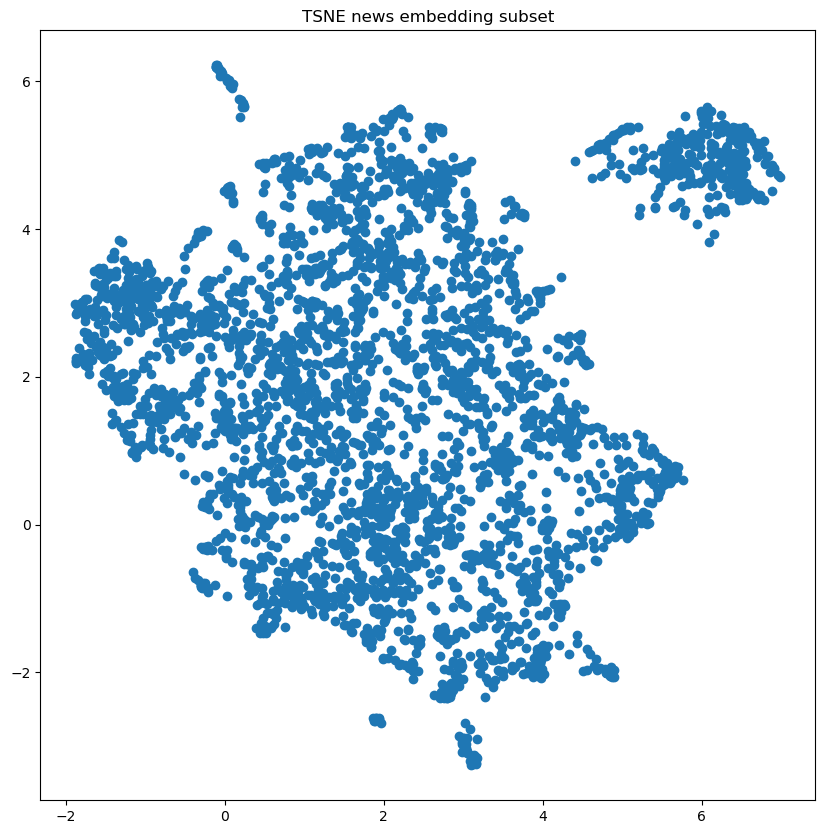

In [36]:
umap_news_embeddings_subset = UMAP(n_components=64, metric='cosine').fit_transform(
    sent_embeddings[indices]
)

umap_news_embeddings_draw_subset = UMAP(n_components=2, metric='cosine').fit_transform(
    sent_embeddings[indices]
)

plt.figure(figsize=(10, 10))
plt.title("TSNE news embedding subset")
plt.scatter(umap_news_embeddings_draw_subset[:, 0], umap_news_embeddings_draw_subset[:, 1])
plt.show()

### KMEANS

C:\Users\Andrii\anaconda3\envs\IASA_NLP\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


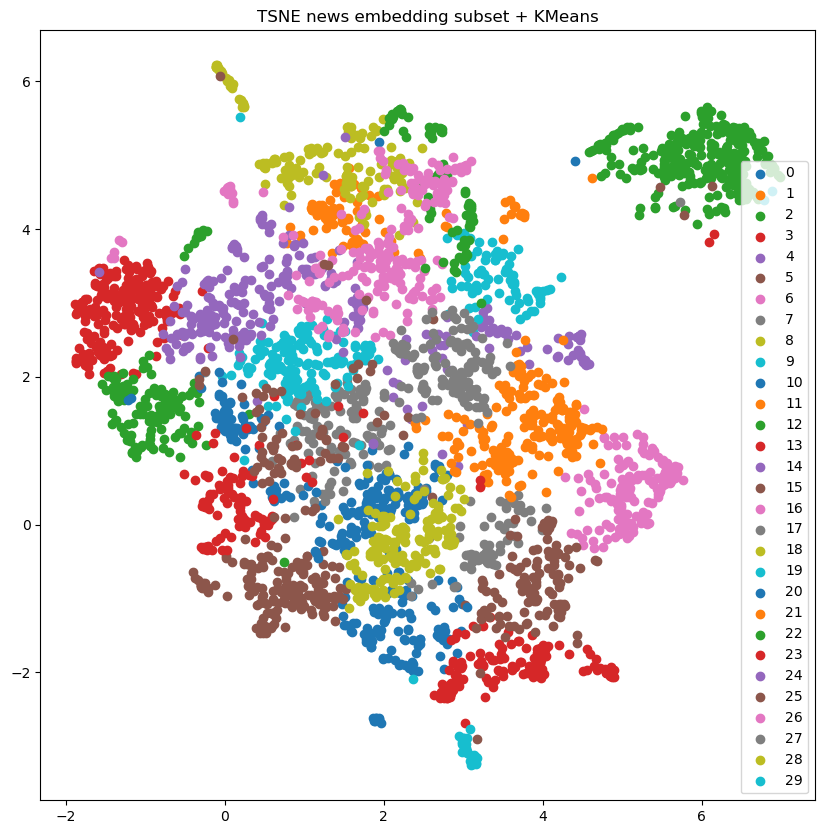

In [37]:
kmeans_clusts_news_embeddings_subset = KMeans(
    n_clusters=30,
    random_state=42,
    init="k-means++"
).fit_predict(umap_news_embeddings_subset)

plt.figure(figsize=(10, 10))
plt.title("UMAP news embedding subset + KMeans")
for clust in np.unique(kmeans_clusts_news_embeddings_subset):
    plt.scatter(
        umap_news_embeddings_draw_subset[kmeans_clusts_news_embeddings_subset == clust, 0],
        umap_news_embeddings_draw_subset[kmeans_clusts_news_embeddings_subset == clust, 1],
        label=str(clust)
    )
plt.legend()
plt.show()

In [38]:
df[indices][kmeans_clusts_news_embeddings_subset == 0]['content'].sample(8, random_state=42).to_list()

['У Тюменській області РФ палає житловий будинок: є постраждалі\n\nРосЗМІ запевняють, що в будівлі вибухнув газ. Відомо про щонайменше трьох постраждалих.',
 '⚡️ На Волині блискавка влучила у міну\n\nСьогодні, 5 серпня, під час грози поблизу прикордонного села Гута на Волині блискавка потрапила у міну. Про це повідомили місцеві жителі.\n\nВід розряду міна здетонувала та понищила дорогу.\n\nТакож, інформацію про інцидент підтвердили у Волинській ОВА.\nВ ОВА уточнили, що вибух пошкодив ґрунтову дорогу.\n\n🇺🇦 Новини.LIVE Львів',
 "У КМВА розповіли про попередні наслідки атаки на столицю:\n\n- пошкодження у Солом'янському та Святошинському районах\n- пожежа\n- працюють екстрені служби\n- даних про постраждалих наразі немає\n\n🇺🇦📞 Ми у Viber",
 'Телефони загиблих у селі Гроза розривалися від дзвінків до самісінького ранку',
 'Через нічний обстріл Миколаївщини обмежили рух поїздів\n\nОкупанти завдали удару по інфраструктурі області. Унаслідок цього тимчасово обмежено рух поїздів між Миколаєв

In [39]:
df[indices][kmeans_clusts_news_embeddings_subset == 1]['content'].sample(8, random_state=42).to_list()

['Зеленский провів телефонну розмову з президентом Азербайджану Ільхамом Алієвим \n\n«Подякував йому за значну гуманітарну допомогу, яку Азербайджан надає Україні, зокрема в енергетичному секторі з наближенням зими. Також обговорили регіональну безпеку, актуальні виклики та формати взаємодії», — йдеться у повідомлення.',
 "БОРТНІК: Скандал з ветераном СС «Галичина» у Канаді. Чи піде Зеленський на вибори? / Прямий ефір\n\nРуслан Бортнік, директор Українського інституту політики у гостях студії Вечір.LIVE. Говоримо про скандал з ветераном СС у Канаді, перше інтерв'ю Рустема Умєрова, ухилянтів від мобілізації та другий президентський термін Зеленського.",
 '▶️ ПРЯМИЙ ЕФІР: Карасьов: Світ палає, хто наступний? «важка» мобілізація, Китай І США домовляться? \n\nХАМАС почав війну з Ізраїлем. Понад 250 загиблих ізраїльтян, ЦАХАЛ витісняє бойовиків з півдня і завдає ударів по Газі. Як світ відреагував на нову війну на Сході? Яка ситуація зараз в Україні? Чи вплине війна в Ізраїлі на допомогу Ук

In [40]:
df[indices][kmeans_clusts_news_embeddings_subset == 2]['content'].sample(8, random_state=42).to_list()

['Ізраїль зазнав безпрецедентної за жорстокістю атаки та має право на захист, — Путін\n\nПрезидент РФ за тиждень після нападу ХАМАС висловив підтримку Ізраїлю. Під час саміту глав країн СНД він заявив, що Ізраїль має право на захист. \n\nТакож Путін сказав, що конфлікт має бути вирішений мирним шляхом — утворенням незалежної держави Палестини. Слід зазначити, що переговори щодо утворення Палестинської держави припинилися після приходу до влади в Секторі Гази угруповання ХАМАС.\n\nОкрім цього, Путін запропонував посередництво Кремля у вирішенні конфлікту.',
 'Перемовини Байдена з арабськими лідерами були скасовані за їхньою ініціативою після атаки на лікарню в Газі\n\nЗапланований раніше візит Джо Байдена до Йорданії був скасований, повідомив пул Білого дому. Президент США мав зустрітися з королем Абдаллою II, президентом Палестини Махмудом Аббасом і президентом Єгипту Абделем Фаттахом ас-Сісі, щоб спробувати покласти край війні між Ізраїлем і ХАМАС та досягти миру в Палестині.\n\nКерів

Upon human analysis of the above groups, we can conclude that the KMEANS + UMAP algorithm, while appearing to only have similar topics in cluster 2, is not ideal due to the presence of different exceptions in the other two examples.

### DBSCAN

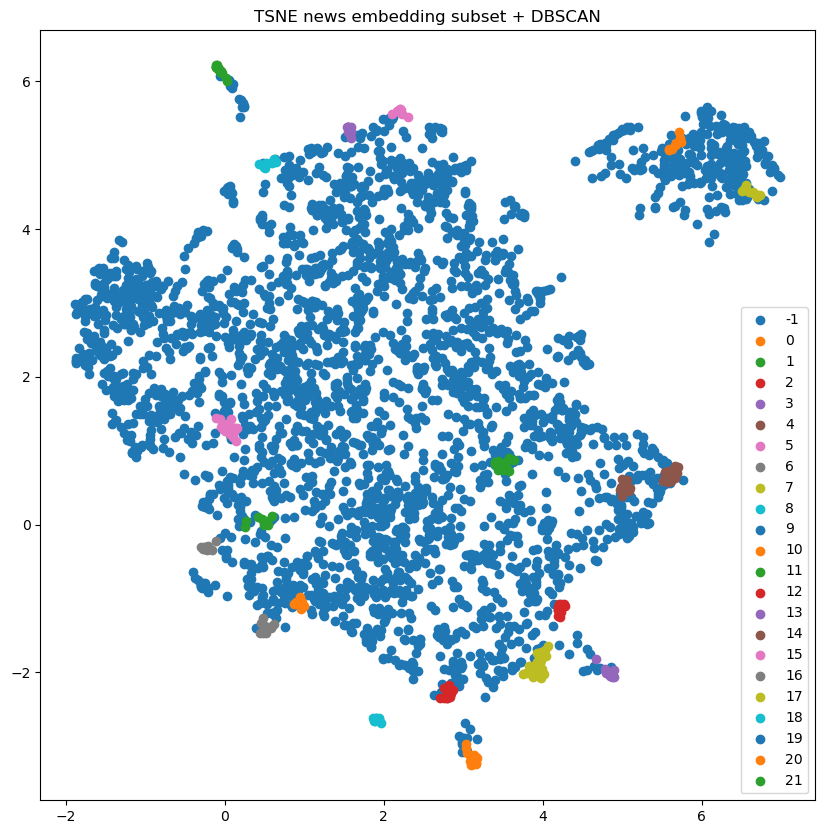

In [41]:
dbscan_clusts_news_embeddings_subset = DBSCAN(
    eps=0.000005,
    min_samples=10,
    metric='cosine'
).fit_predict(umap_news_embeddings_subset)

plt.figure(figsize=(10, 10))
plt.title("UMAP news embedding subset + DBSCAN")
for clust in np.unique(dbscan_clusts_news_embeddings_subset):
    plt.scatter(
        umap_news_embeddings_draw_subset[dbscan_clusts_news_embeddings_subset == clust, 0],
        umap_news_embeddings_draw_subset[dbscan_clusts_news_embeddings_subset == clust, 1],
        label=str(clust)
    )
plt.legend()
plt.show()

In [42]:
df[indices][dbscan_clusts_news_embeddings_subset == 0]['content'].sample(8, random_state=42).to_list()

['В тимчасово окупованому Севастополі лунають вибухи, — ЗМІ',
 'Херсон під обстрілом ворога з лівобережжя, — місцеві ЗМІ',
 'На одній з вулиць Одеси повзає величезна змія\n\nЗвідки вона втекла — невідомо. Втім, вона вже встигла стати зіркою мережі. \n\n🇺🇦 Новини.LIVE Одеса',
 'У Севастополі лунають вибухи, — місцеві ЗМІ',
 'В окупованому Скадовську пролунала серія вибухів, — ЗМІ',
 '❗️В Херсоні пролунав потужний вибух, — місцеві ЗМІ',
 'У Хмельницькій області знову чути вибухи, — місцеві ЗМІ\n\n🇺🇦📞 Ми у Viber',
 'На рейді Севастополя підірвався корабель, — місцеві ЗМІ\n\nПопередньо, вибухнув один із носіїв «Калібрів». Над морем підіймається чорний дим.']

In [43]:
df[indices][dbscan_clusts_news_embeddings_subset == 1]['content'].sample(8, random_state=42).to_list()

["🔥 Львів'янка Христина Погранична здобула три медалі на Всесвітній Універсіаді в Китаї\n\nДві з цих медалей - найвищого гатунку! У фіналах окремих видів Христина виборола золото у вправі з обручем та у вправі зі стрічкою.\n\nРаніше гімнастка завоювала срібло у багатоборстві.\n\n👍- Вітаємо! \n🧡- Пишаємось!\n\n🇺🇦 Новини.LIVE Львів",
 "14-річний львів'янин став чемпіоном України з тенісу\n\nЧемпіонат України з тенісу серед гравців до 16-ти років відбувся в Ужгороді. Микола Грабар став чемпіоном в особистому розряді до 16-ти років. \n\nОкрім того, Микола Грабар разом з 13-річним львів'янином Остапом Таламою стали третіми у парному розряді. \n\n👍 Вітаємо!  \n\n🇺🇦\xa0Новини.LIVE Львів",
 'Спортсменка з Львівщини виборола дві срібні медалі на Чемпіонаті світу з\xa0параармрестлінгу\n\nНа змаганнях у Казахстані взяли участь 1500 спортсменів з 50 країн.\n\nАнна Кушнір змагається серед незрячих армрестлерок у ваговій категорії 60 кг. Дівчина родом з Рави-Руської.\n\nВона кількаразова призерка Че

In [44]:
df[indices][dbscan_clusts_news_embeddings_subset == 2]['content'].sample(8, random_state=42).to_list()

['Вибухи в Києві, — місцеві пабліки\n\n🇺🇦📞 Ми у Viber',
 'Вибухи в передмісті Запоріжжя, — місцеві пабліки\n\n🇺🇦📞 Ми у Viber',
 'У Херсоні лунають вибухи, — місцеві пабліки',
 'У Херсоні чути вибухи, — місцеві пабліки\n\n🇺🇦 Ми у Viber',
 'Вибухи в Запоріжжі, — місцеві пабліки\n\n🇺🇦📞 Ми у Viber',
 'У тимчасово окупованому Донецьку пролунали вибухи: у декількох районах підіймається густий чорний дим, — місцеві пабліки',
 'У Києві ще одне самогубство, — місцеві пабліки\n\nПовідомляється, що з 13-го поверху вистрибнув молодий хлопець. Офіційної інформації наразі немає.',
 'Щось горить в районі Гвардійського в Криму, — місцеві пабліки\n\nСаме в цьому населеному пункті розташована авіабаза окупантів та склади БК.']

DBSCAN clustering, after applying UMAP algorithm for dimensionality reduction, gives 23 different clusters, that is lower amount of clusters then we set in previous. Although different clusters have only similar topics in them, algorithm is not working like intended because clusters 0 and 2 have similar topic.

### HDBSCAN

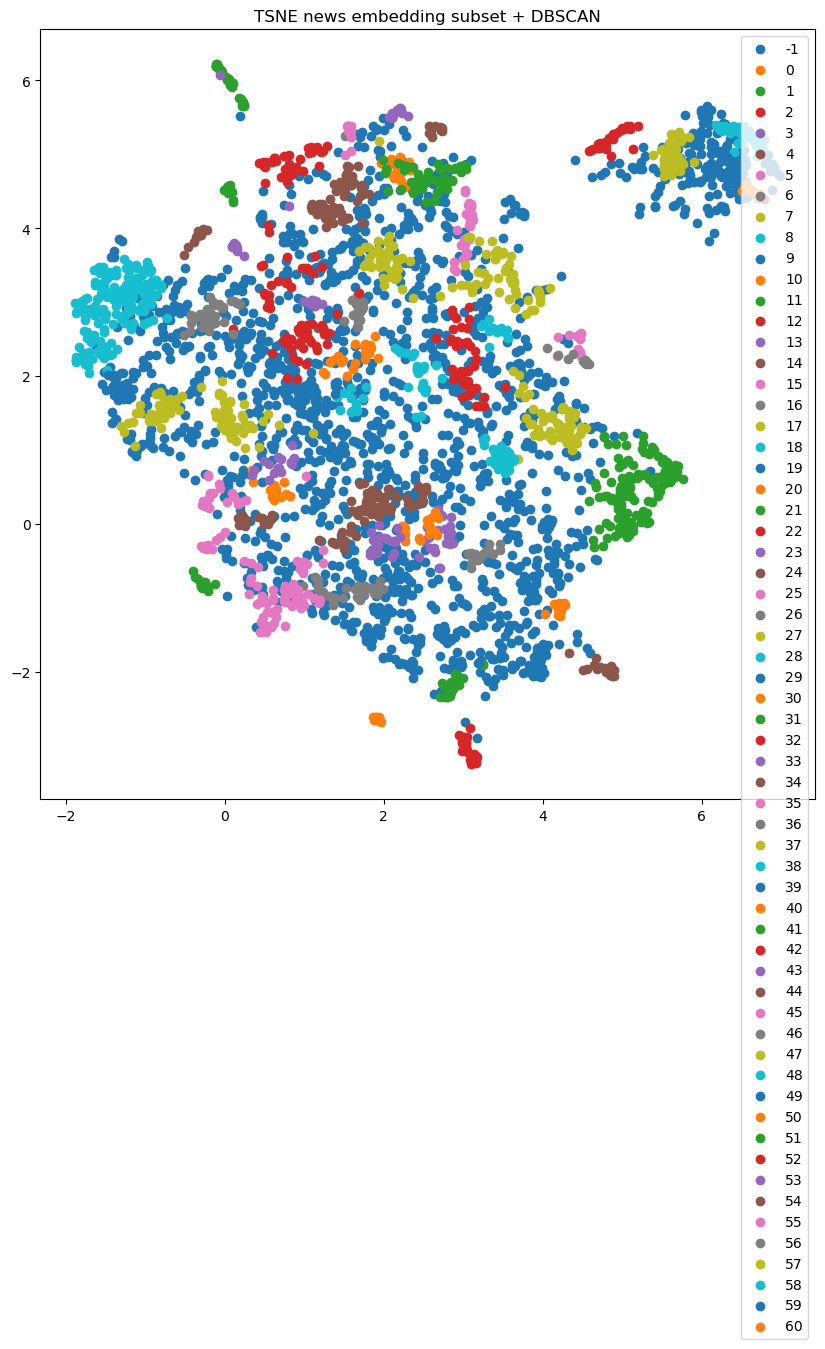

In [45]:
hdbscan_clusts_news_embeddings_subset = HDBSCAN(
    min_cluster_size=10,
    max_cluster_size=200,
).fit_predict(umap_news_embeddings_subset)

plt.figure(figsize=(10, 10))
plt.title("UMAP news embedding subset + DBSCAN")
for clust in np.unique(hdbscan_clusts_news_embeddings_subset):
    plt.scatter(
        umap_news_embeddings_draw_subset[hdbscan_clusts_news_embeddings_subset == clust, 0],
        umap_news_embeddings_draw_subset[hdbscan_clusts_news_embeddings_subset == clust, 1],
        label=str(clust)
    )
plt.legend()
plt.show()

In [46]:
df[indices][hdbscan_clusts_news_embeddings_subset == 0]['content'].sample(8, random_state=42).to_list()

['У Криму перекрили рух Керченським мостом, — місцеві пабліки\n\nПро причини не повідомляють.\n\n🔥 — Як вважаєте, буде чергова «бавовна»?',
 'Рух Кримським мостом знову перекрили, — місцеві канали\n\nПовідомляють про нібито ракетну небезпеку.\n\n🔥 — Чекаємо «влучних» новин!',
 'Рух Кримським мостом вкотре призупинено\n\nПро це повідомляють місцеві ЗМІ.\n\nПричина зупинки переправи не повідомляється.\n\n🇺🇦 Новини.LIVE Одеса',
 'Окупанти нібито відбудували Кримський міст, — заступник голови уряду РФ\n\nРосіяни наголошують, що вже відкрили всі смуги руху на мосту, який у липні атакували дрони СБУ та ВМС.\n\nЯк думаєте, як довго ця споруда простоїть неушкодженою?\n🤡 — Максимум декілька днів, до нової спецоперації СБУ.\n😀 — До сьогоднішньої ночі.\n👇 — Пишу свій варіант у коментарі.',
 'У Міноборони РФ заявили, що на Кримському мосту на цілу ніч перекриватимуть рух\n\nУ відомстві запевняють, що міст перекриють із 21:00 2 жовтня до 06:00 3 жовтня «у зв‘язку з проведенням відновлювальних робіт

In [47]:
df[indices][hdbscan_clusts_news_embeddings_subset == 1]['content'].sample(8, random_state=42).to_list()

['3:1! Українська збірна з футболу перемагає Мальту на відборі на Євро-2024\n\n🎉 — Вітаємо переможців!',
 'Ірландія та Румунія також бойкотують футбольні змагання УЄФА через участь у них російських команд U-17\n\nЗагалом проти росіян виступили вже 11 збірних, серед них, Україна, Польща, Латвія, Литва, Данія, Швеція, Фінляндія, Англія, Норвегія.\n\nНагадаємо, 26 вересня в УЄФА заявили про допуск російських команд U-17 (вік гравців — до 17 років) до європейських змагань.',
 'Українська збірна U21 отримала другу перемогу у відборі на Євро-2025 \n\nЮні футболісти обіграли Люксембург з рахунком 3:0.\n\n🎉 — Вітаємо переможців! Так тримати!\n\nВідео: УАФ',
 '😍 Україну на "Дитячому Євробаченні" представить Анастасія Димид із Франківщини\n\nНа національному відборі жюрі віддало їй 4 бали, а глядачі — 5 балів, таким чином вона набрала 9 балів та опинилася на першому місці турнірної таблиці.\n\n💜 - для юної співачки\n\n🇺🇦 Новини.LIVE Львів',
 'Спортсменка з Львівщини виборола дві срібні медалі на

In [48]:
df[indices][hdbscan_clusts_news_embeddings_subset == 2]['content'].sample(8, random_state=42).to_list()

['Евакуація з Ізраїлю: як українцям повернутися додому?\n\nЖурналістка Новини.LIVE Марія Кагал, яка зараз перебуває в Ізраїлі, розповіла, як можна вилетіти з охопленої війною країни, які авіакомпанії продовжують працювати та скільки коштують квитки.',
 'Кількість загиблих українців в Ізраїлі зросла до семи осіб, — МЗС \n\nЗа даними міністерства, ще 9 українців поранені і 9 — зниклі безвісти.',
 'В Ізраїлі загинув ще один українець: в МЗС підтвердили вже третю смерть нашого громадянина\n\nЩе 9 українців — поранені, їхній стан, а також місця госпіталізації уточнюються, повідомив речник відомства Олег Ніколенко. Шестеро громадян України — серед зниклих безвісти. Їхнім пошуком займаються дипломати разом з ізраїльськими правоохоронцями.',
 '13 українців загинули під час нападу ХАМАС на Ізраїль\n\nПро це повідомила Олена Зеленська після розмови з першою леді Ізраїль Міхаль Герцог. Серед поранених українців — хлопчик, мама якого загинула під час нападу терористів.',
 'Ізраїль — Україна: найси

HDBSCAN + UMAP gives 62 different clusters, the highest in our work, despite the fact that it's too much. This approach is the best option, thanks to its consistent capability to cluster provided data.

# Conclusion

The best clustering algorithm is HDBSCAN. Despite it didn't work good with PCA HDBSCAN was the best one so far with TSNE and UMAP. The only difference was UMAP had twice amount of clusters of TSNE, that means that if you using HDBSCAN + UMAP it could be appropriate to use some other algorithms to reduce number of clusters as postprocessing.